# **Get and use mask from grad-cam**
# A tutorial to learn how to get and reuse for other purpose the information returned by grad-cam project.
How can i use and apply a mask, based on information returned by grad-cam?

In this tutorial you will:
- Get an overview on logical operations.
- Learn how to get and reuse a mask returned by grad-cam system.
- See an example of grad-cam mask based application.

# 1. **Logical Operations**
First of all, if you want to get and use a mask you have to learn about **Logical Operations** (operation used to process selective portions of an image).

As you should know, images can be represented in two-dimensional arrays (*width x height*) and each two-dimensional array represents an **image channel**. <br>
For example:
- **RGB** has 3 channels $→$ ***red, green, blue***
- **BGR** the same, but in ***reverse order***
- **GRAYSCALE** has only one channel
- then there can be **other** formats in which there is a fourth channel called **ALPHA CHANNEL**

Each element in an array represents the **intensity value of each pixel** in the image, in the range [0-255]:
- the higher the value, the higher the intensity
- a value = 0 indicates that the pixel is off (it is black)

*For example, in a grayscale format image, a value of 255 indicates pure white.*

Pixel values can be represented in binary (therefore with a value of 0 or 1).

Logical operators perform operations on the latter in this way: <br>

<img src="../examples/logical_operations.jpeg" width="50%" />

**You can use these operators using the cv2 library**.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import models
from pytorch_grad_cam import GradCAM,HiResCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad, \
    GradCAMElementWise
    

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 2. **Bitwise Operations**
Some operation are needed to use mask for our purpose, they are called **bitwise operations**.

#### **The Function Syntax is the following:**
Example API for **`bitwise_and()`**. Others include: **`bitwise_not()`**, **`bitwise_or()`**, **`bitwise_xor()`** 

``` python
img = cv2.bitwise_and( src1, src2[, dst[, mask]] )
```

`img`: Output array that has the same size and type as the input arrays.

The function has **2 required arguments**:

1. `src1`:	first input array or a scalar.
2. `src2`:	second input array or a scalar.

An important optional argument is:

1. `mask`:	optional operation mask, 8-bit single channel array, that specifies elements of the output array to be changed.


### **For more explainaions see OpenCV Documentation**

[**`bitwise_and()`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#ga60b4d04b251ba5eb1392c34425497e14)
[**`bitwsie_not()`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#ga0002cf8b418479f4cb49a75442baee2f)
[**`bitwise_or()`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#gab85523db362a4e26ff0c703793a719b4)
[**`bitwise_xor()`**](https://docs.opencv.org/4.5.2/d2/de8/group__core__array.html#ga84b2d8188ce506593dcc3f8cd00e8e2c)

# 3. **Using bitwise operation on grad-cam project output**
Okay, now you should have the basics to understand what we're going to do.

First of all our goal is to perform grad-cam on an image of your choice in which we want to obtain the mask.

In this example we are going to use the following image.

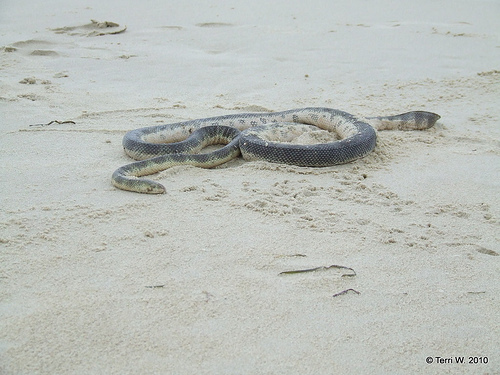

In [3]:
from IPython.display import Image
img_path = '../examples/sea_snake.JPEG'
Image(filename=img_path) 

#### **Let's now run grad-cam on it**

In [ ]:
# Prepare the model and choose target layer
model = models.resnet50(pretrained=True)
target_layers = [model.layer4]

In [5]:
# Load image
rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
rgb_img = np.float32(rgb_img) / 255
img_size = rgb_img.shape
input_tensor = preprocess_image(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])


# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category (for every member in the batch) will be used.
# You can target specific categories by
# targets = [e.g ClassifierOutputTarget(65)]
targets = None

# Using the with statement ensures the context is freed, and you can
# recreate different CAM objects in a loop.
cam_algorithm = GradCAM
with cam_algorithm(model=model,
                    target_layers=target_layers) as cam:

    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets)

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

### **Now we can get and show the mask**

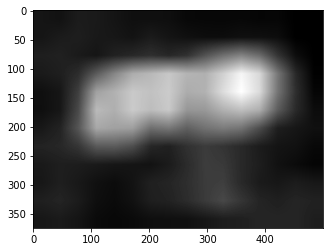

In [6]:
mask = grayscale_cam * 255  # Make range between 0-255
plt.imshow(mask, cmap='gray')

#### **If we want we can clean the mask using a threshold**
Obviusly you can already use the mask but for some task is needed to make some clean process. We can do this using, for example, a threshold function.

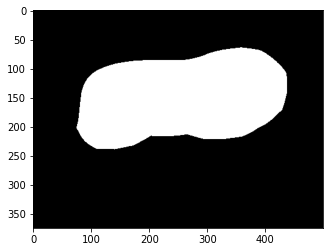

In [7]:
retval, img_thresh = cv2.threshold(mask, 80, 255, cv2.THRESH_BINARY) # thresholding to clean the mask
mask = img_thresh.astype(np.uint8)
plt.imshow(mask, cmap='gray')

In this case i used a fix threshold but it can be also adaptive threshold.

#### 4. **Now let's see an example of using to report the identified image to another background**
Obviusly it is not the main use of the mask but i use that example because you can see all operation globally.

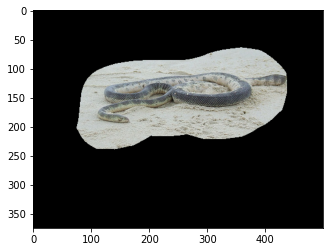

In [8]:
img_applied_mask = cv2.bitwise_and(rgb_img, rgb_img, mask = mask)   # Section the original image with the mask
img_applied_mask *= 255 # Make range between 0-255
img_applied_mask = img_applied_mask.astype(np.uint8)  # Convert to np.uint8 for the further operations
plt.imshow(img_applied_mask)

**Let's choose a background**

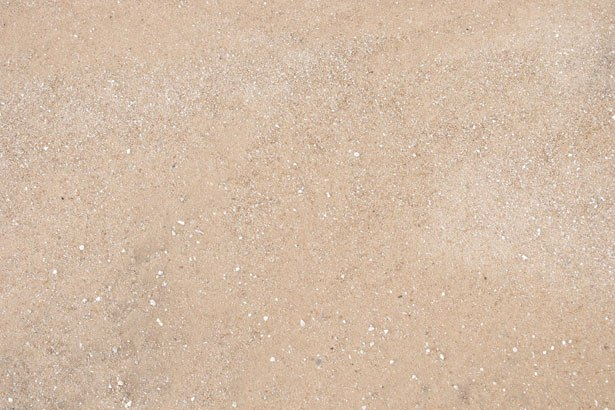

In [9]:
img_path = '../examples/background.jpg'
Image(filename=img_path) 

In [14]:
backgruound = cv2.imread(img_path, 1)[:, :, ::-1]
backgruound = cv2.resize(backgruound, (img_size[1], img_size[0])) # Resize background image in the same size of original image

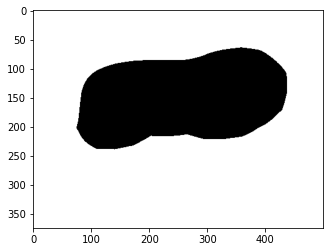

In [11]:
img_logo_mask_inv = cv2.bitwise_not(mask) # Create an inverse mask
plt.imshow(img_logo_mask_inv, cmap='gray')

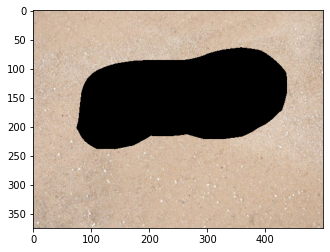

In [16]:
img_foreground = cv2.bitwise_and(backgruound, backgruound, mask = img_logo_mask_inv) # Isolate the foreground using the inverse mask.
plt.imshow(img_foreground)

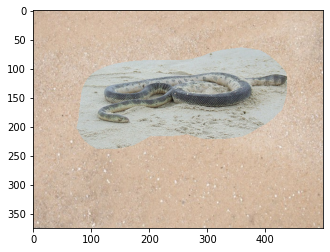

In [17]:
result = cv2.add(img_applied_mask, img_foreground) # Add the two previous results to obtain the final result.
plt.imshow(result)